In [9]:
import os, sys
import numpy as np
from numpy.random import multinomial
import process_relion
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [10]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [22]:
#data path
print('all module loaded')
file_path='./real_star_file/GSS20173_Reja_300.star'
file_info=process_relion.read_relion(file_path)
relion_31=True

all module loaded


In [62]:
# parameters
#window size
w = 1

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44]
ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46]
#ignore_classes=[]

#embedding size
embedding_size=100

#


In [63]:
if relion_31:
    #read data (relion3.1)
    dataset=file_info.getRdata_31()
    optics=file_info.extractoptic()
else:
    #read relion 3.0
    dataset=file_info.getRdata()

In [64]:
metadata=dataset[0]
print(metadata)
data=dataset[1]
print(data[0])
corpus_information=process_relion.process_helical(dataset).extarct_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())

## import sentence from txt
#helical_path='./real_star_file/helical.txt'
#corpus=[]
#for line in open(helical_path).readlines():
#    if len(line.strip()) == 0:
#        continue    
#    else:
#        corpus.append(line.split())

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnAngleRotFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['310.075035', '3514.839698', '1', '90.000000', '64.916406', '0.000000', '0.500000', '0.500000', '000001@Extract/job261/Micrographs/19oct04a_GSS17_Lacey1_GO_Aff_00006gr_00004sq_00002hl_00002es-a-DW.mrcs', 'Micrographs/19oct04a_GSS17_Lacey1_GO_Aff_00006gr_00004sq_00002hl_00002es-a-DW.mrc', '1', '4.324988', '0.232637', '21254.011719', '20968.203125', '19.22974

In [65]:
vocabulary = set(itertools.chain.from_iterable(corpus))
vocabulary_size = len(vocabulary)

In [66]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [67]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [68]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [69]:
# convert to windoes vector
corpus=corpus
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus:
    for i, word in enumerate(text):
        if int(word) in ignore_classes:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if int(text[j]) in ignore_classes:
                continue
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 452055 pairs of target and context words


In [70]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [71]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [72]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [73]:
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)))
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break

Loss:  tensor(10678.6982, device='cuda:0')
Loss:  tensor(3182.6619, device='cuda:0')
Loss gain: 70.19615936279297%
Loss:  tensor(2265.7637, device='cuda:0')
Loss gain: 78.78239440917969%
Loss:  tensor(2001.1230, device='cuda:0')
Loss gain: 81.26061248779297%
Loss:  tensor(1893.6980, device='cuda:0')
Loss gain: 82.2665786743164%
Loss:  tensor(1835.2827, device='cuda:0')
Loss gain: 42.33497619628906%
Loss:  tensor(1799.7396, device='cuda:0')
Loss gain: 20.568078994750977%
Loss:  tensor(1781.0171, device='cuda:0')
Loss gain: 10.99912166595459%
Loss:  tensor(1768.3809, device='cuda:0')
Loss gain: 6.617588520050049%
Loss:  tensor(1758.7761, device='cuda:0')
Loss gain: 4.168654441833496%
Loss:  tensor(1751.6135, device='cuda:0')
Loss gain: 2.6740589141845703%
Loss:  tensor(1745.3496, device='cuda:0')
Loss gain: 2.0026466846466064%
Loss:  tensor(1740.6298, device='cuda:0')
Loss gain: 1.5692942142486572%
Loss:  tensor(1736.4044, device='cuda:0')
Loss gain: 1.2720041275024414%
Loss:  tensor(173

EMBEDDINGS.shape:  torch.Size([50, 100])
1
2
3
4
5
6
7
8


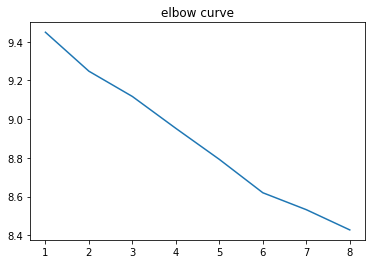

In [74]:
EMBEDDINGS = net.target.weight.data.cpu()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

iris = load_iris()
x = iris.data

res = []
n_cluster = range(1,9)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

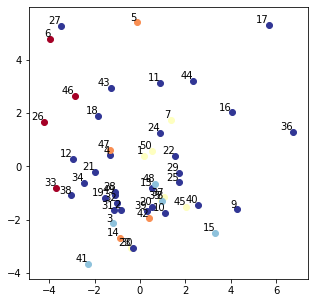

In [75]:
# see the 2D class segments embedding
cluster_number=6
kmeans_best = KMeans(n_clusters=cluster_number).fit_predict(EMBEDDINGS)
pca = PCA(n_components=2).fit_transform(EMBEDDINGS)
EMBEDDINGS = net.target.weight.data.cpu()

plt.figure(figsize = (5, 5))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(pca[i][0], pca[i][1],color=plt.cm.RdYlBu(kmeans_best[i]/4))
    plt.annotate(index_to_word[i], xy = (pca[i][0], pca[i][1]), \
        ha='right',va='bottom')
plt.savefig("w2v.png")
plt.show()

In [76]:
word_to_cluster={}
for i in range(cluster_number):
    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#for i in range(1,vocabulary_size+1):
#    word_to_cluster.append((i,kmeans_best[word_to_index[str(i)]]))
print(word_to_cluster)

{'0': array([26, 28, 32, 41], dtype=int64), '1': array([ 4, 33, 36, 38], dtype=int64), '2': array([ 1,  9, 13, 21, 37, 40, 45], dtype=int64), '3': array([16, 27, 31, 42, 47], dtype=int64), '4': array([ 2,  5,  6,  7,  8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 22, 24, 25,
       29, 30, 34, 35, 43, 44, 46, 49, 50], dtype=int64), '5': array([ 3, 23, 39, 48], dtype=int64)}


In [77]:
#using the histogram method to cluster 

#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

In [78]:
filament_score=[]
for filament in corpus:
    score=torch.zeros(embedding_size)
    counts=0
    for i in filament:
        if int(i) in ignore_classes:
            continue
        counts+=1
        score=score+EMBEDDINGS[word_to_index[i]]
    if counts==0:
        continue
    score=score/counts
    print(counts)
    filament_score.append(np.array(score))

118
50
67
81
101
51
116
99
62
74
82
50
74
63
42
32
74
124
57
60
67
76
55
54
83
59
56
157
50
49
70
66
128
55
121
58
45
53
76
44
42
60
56
39
37
46
33
59
123
81
128
94
48
59
65
74
68
57
56
81
62
54
28
165
88
49
38
41
56
58
50
79
53
79
62
14
55
101
235
21
48
30
47
78
76
42
34
42
49
116
23
30
74
40
43
81
82
70
31
37
83
138
90
109
35
40
92
28
41
86
58
48
43
84
71
52
33
32
38
41
41
26
38
109
102
139
72
55
56
77
53
44
70
32
49
60
62
157
34
118
30
20
28
105
73
70
59
107
57
93
33
30
40
78
55
47
64
43
55
43
71
48
44
36
109
42
57
34
43
74
99
70
44
86
35
24
42
52
151
118
66
52
103
93
87
63
47
14
19
137
58
41
39
71
85
67
34
58
64
91
47
13
45
29
119
60
51
108
76
51
54
48
34
80
77
13
14
1
12
15
14
68
85
200
37
61
46
41
63
36
38
40
77
63
86
36
59
59
158
33
55
52
35
57
50
163
115
38
72
42
104
41
27
101
25
23
17
37
101
38
33
47
31
58
117
63
122
73
55
158
157
78
21
47
51
53
41
27
70
27
51
81
93
96
66
37
66
51
57
59
88
161
79
56
56
53
46
77
48
48
123
32
72
44
31
50
32
38
38
41
16
19
100
43
41
40
107
52
65


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




31
33
113
75
27
62
157
15
28
88
60
52
62
127
51
55
58
55
61
48
19
70
113
63
37
36
25
122
114
64
71
35
129
69
82
101
81
61
41
36
96
57
61
35
56
76
69
68
58
112
29
122
33
96
139
50
121
56
13
11
65
30
77
65
28
74
26
146
74
59
34
134
88
39
51
48
46
32
114
45
41
38
73
159
22
82
57
120
54
77
86
62
68
88
33
50
83
105
125
22
55
30
76
48
40
18
52
29
49
53
96
61
47
68
93
83
55
76
54
67
106
35
28
59
20
23
121
103
46
33
37
30
77
69
90
50
43
38
37
31
33
27
76
130
84
31
20
48
105
123
77
25
58
116
74
61
56
54
22
32
45
58
161
50
34
27
76
236
65
26
21
55
76
41
29
119
23
76
74
57
80
51
58
35
52
33
54
30
34
64
67
62
89
153
32
120
106
57
49
28
33
40
112
68
29
32
43
27
36
142
66
73
30
67
47
16
214
44
23
29
60
88
64
78
44
42
39
90
74
42
47
90
58
84
86
82
73
87
124
62
87
21
40
138
67
60
67
54
86
100
112
68
92
25
54
70
37
59
101
31
138
74
55
59
82
41
39
69
68
59
73
50
74
94
70
73
50
33
26
46
41
25
31
43
43
103
39
50
31
69
93
64
43
34
29
47
34
62
101
70
47
56
53
41
27
22
38
104
90
58
82
39
74
72
75
58
69
105


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




44
36
43
107
40
61
47
73
107
96
113
37
44
32
48
68
62
42
50
49
84
59
123
55
74
68
54
27
110
45
84
106
39
21
14
83
64
24
77
128
96
47
50
44
25
118
82
81
72
81
55
59
153
42
113
51
42
43
35
85
65
52
70
70
36
64
36
76
48
82
73
49
46
81
65
56
79
86
55
46
95
46
71
29
63
42
40
48
68
62
150
60
80
74
57
26
83
63
53
155
48
193
74
54
121
198
58
84
56
63
39
67
43
125
51
48
38
66
48
62
43
104
123
59
49
23
33
38
24
31
135
52
54
81
62
85
136
105
28
73
90
83
27
22
25
33
46
38
26
40
82
49
80
52
114
10
30
24
22
16
18
28
63
75
65
30
33
27
31
157
102
96
68
65
79
97
27
45
63
56
33
41
34
117
88
66
41
12
61
144
105
180
36
77
26
127
135
58
105
206
26
130
78
126
66
47
27
30
48
64
24
41
64
76
48
153
83
37
34
70
46
22
29
19
69
160
53
35
80
28
144
4
12
34
94
104
30
17
52
28
64
121
38
22
24
24
91
80
26
66
50
40
27
123
71
71
81
59
108
92
62
40
77
79
80
50
187
31
34
132
41
43
36
24
104
117
79
34
45
28
27
52
132
71
22
43
124
52
44
22
45
28
99
46
142
45
26
71
73
14
26
88
44
47
32
38
38
56
32
89
45
28
24
82
77
88
42
3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



78
72
103
54
51
42
47
39
70
107
151
90
48
37
21
26
69
39
144
55
59
55
158
84
34
40
91
45
26
42
79
129
105
97
58
130
69
19
20
44
93
81
42
53
36
52
37
22
31
41
16
94
53
69
25
119
85
64
101
48
38
88
108
52
48
86
33
81
73
60
139
70
75
151
73
39
116
241
47
163
67
67
47
50
28
126
53
61
45
52
22
20
114
48
42
45
47
45
34
58
30
46
62
80
46
28
27
32
38
101
80
53
48
53
62
194
58
48
24
38
38
51
41
37
21
90
71
114
162
40
35
60
43
30
49
29
56
51
71
29
38
27
138
109
56
50
88
37
85
41
79
47
56
104
80
25
156
120
49
46
34
48
198
107
36
80
168
38
44
57
69
134
59
37
31
99
38
80
74
21
149
55
28
49
68
48
47
61
103
66
44
77
32
68
76
127
57
161
44
126
36
48
27
33
34
47
19
54
35
42
50
35
65
131
57
40
61
31
60
94
55
62
47
108
54
47
131
103
86
26
41
26
33
48
126
51
24
15
54
31
40
69
55
80
36
26
28
43
96
31
50
23
45
88
32
79
86
16
24
109
84
26
60
62
28
30
113
29
20
79
106
66
70
86
52
76
50
65
18
22
30
50
71
39
93
33
52
21
58
20
29
67
71
53
36
87
111
67
116
31
20
53
48
48
56
23
22
22
25
24
32
58
34
73
34
43
60
42


In [79]:
#print(filament_score)
from sklearn.mixture import GaussianMixture
pca_sum = PCA(n_components=2).fit_transform(filament_score)
cluster_pca = KMeans(n_clusters=2).fit_predict(pca_sum)

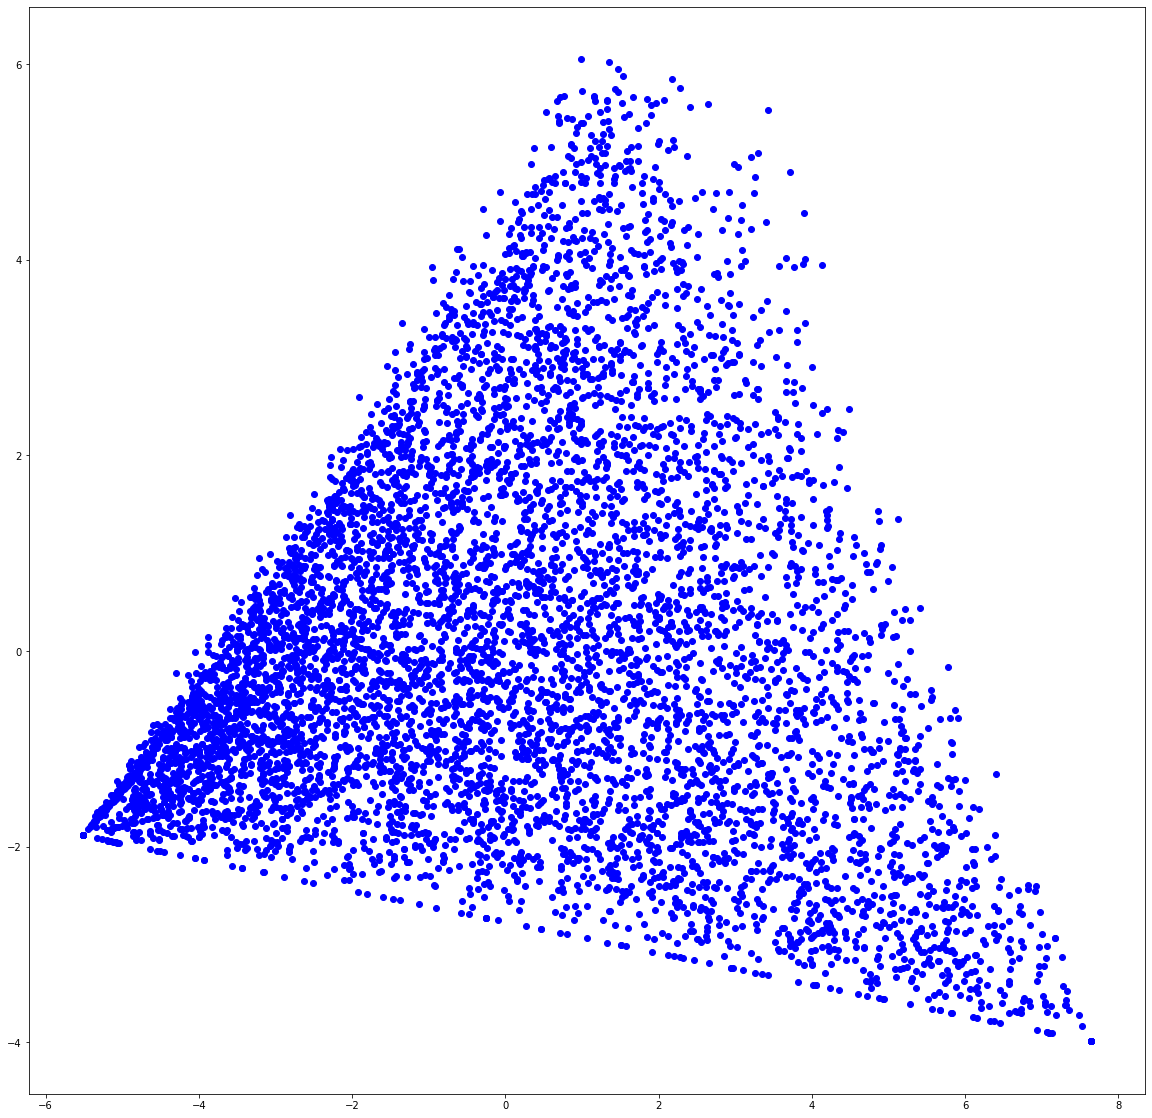

In [80]:
plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(pca_sum[i][0], pca_sum[i][1],color='blue')
plt.savefig(os.path.splitext(file_path)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

In [87]:
import umap
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
reducer = umap.UMAP()
umap = reducer.fit_transform(filament_score)
cluster_umap = SpectralClustering(n_clusters=3).fit_predict(umap)

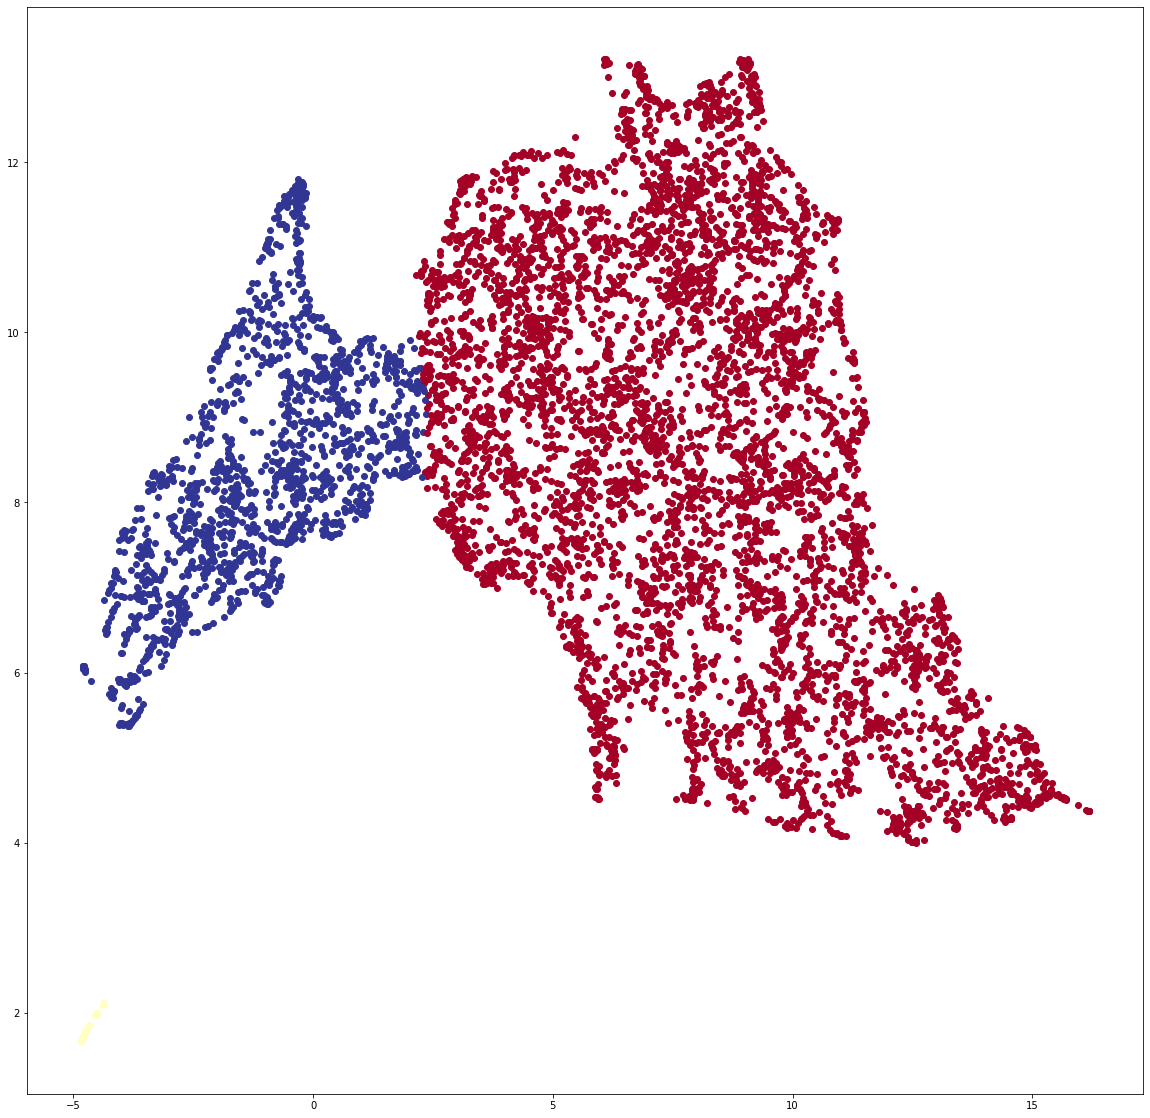

In [107]:
plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(umap[i][0], umap[i][1],color=plt.cm.RdYlBu(cluster_umap[i]/2))
plt.savefig(os.path.splitext(file_path)[0]+"_ignore_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(kmeans_umap[i]/4)

In [83]:
#from sklearn.manifold import MDS
#MDS = MDS(n_components=2).fit_transform(filament_score)

In [84]:
#plt.figure(figsize = (20, 20))
#for i in range(len(cluster_corpus)):
#    plt.scatter(MDS[i][0], MDS[i][1],color='blue')
#plt.savefig(os.path.splitext(file_path)[0]+"_MDS.png")
#plt.show()

In [91]:
for i in range(3):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=cluster_umap
for i in range(len(cluster_choice)):
    lst=corpus[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][6][19:21])
        data_line+=1

In [86]:
# check rate of successful
labels=['38','29']
distribution_hist_all=[]
for i in range(2):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(2):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)

In [94]:
print(len(data),len(cluster0),len(cluster2))

462984 362628 99213


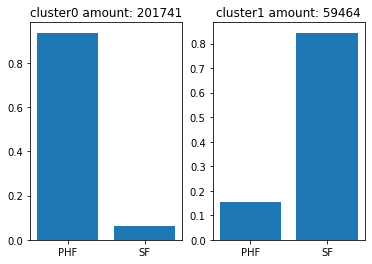

In [41]:
fig, ax = plt.subplots(1,2)
labels_name=['PHF','SF']
for i in range(2):
    ax[i].bar(range(2),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
#plt.savefig('./confusion_matrix/'+"10230_tau_distr_Loss_per10-2.png")

In [232]:
# write relion

In [100]:
for i in range(3):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if relion_31 is True:
        output=process_relion.output_star(file_path,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    else:
        output=process_relion.output_star(file_path,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [101]:
with open('cluster_umap.npy', 'wb') as f:
    np.save(f, umap)

0
